In [36]:
#pip install d2l==1.0.0a1.post0

In [ ]:
#to download a package in colab permanently
'''
import os, sys 
from google.colab import drive 
drive.mount('/content/gdrive') 
nb_path = '/content/notebooks'
#create in the folder Colab Notebooks the symulated link to the folder notebooks
os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
#add a folder called notebooks at the depth of gdrive
sys.path.insert(0, nb_path)  # or append(nb_path)
#The last three lines are what changes the path of the file.
!pip install --target=$nb_path matplotlib_inline
'''

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
import collections
import random
import re
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from d2l import torch as d2l
%matplotlib inline
#here we are importing a file in d2l called torcg.py created by d2l book

In [24]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # flatten a 2d list is needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        #count token frequencies, the function returns tuples like ('e', 17838)
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        #list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + 
                                            [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
            
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            # if tokens are not a list or a tuple are a single char, 
            # then returns the index or unk if not present in the dict
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, "__len__") and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    # to understand property https://www.freecodecamp.org/news/python-property-decorator/
    def unk(self):
        return self.token_to_idx['<unk>']

In [28]:
class TimeMachine(d2l.DataModule):

    def  __init__(self, batch_size, num_inputs, num_trains=10000, num_vals=5000):
        super().__init__()
        self.batch_size = batch_size
        self.num_steps = num_inputs
        self.num_trains = num_trains
        self.num_vals = num_vals
        corpus, self.vocab = self.build(self._download())
        array = torch.tensor([corpus[i:i+num_inputs] for i in range(0, len(corpus)-num_inputs-1)])
        self.X, self.Y = array[:, :-1], array[:, 1:]

    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()
        #means delete all the characters except A-Za-z, replace with space, + means consider also repetitions

    def _tokenize(self, text):
        return list(text)

    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = TensorDataset(*tensors)
        return DataLoader(dataset, self.batch_size, shuffle=train)

    def get_dataloader(self, train):
        idx = slice(0, self.num_trains) if train else slice(self.num_trains, self.num_trains + self.num_vals)
        return self.get_tensorloader([self.X, self.Y], train, idx)

data = TimeMachine(batch_size=2, num_inputs=10)
for X, Y in data.train_dataloader():
    print('X', X, 'Y', Y)
    break

X tensor([[21,  0, 20, 16, 14,  6,  0, 20, 13],
        [ 3, 20,  6, 15, 21,  0, 14, 10, 15]]) Y tensor([[ 0, 20, 16, 14,  6,  0, 20, 13,  6],
        [20,  6, 15, 21,  0, 14, 10, 15,  5]])


# Some statistics

In [29]:
data = TimeMachine(batch_size=2, num_inputs=10)
raw_text = data._download()
text = data._preprocess(raw_text)
tokens = data._tokenize(text)
#tokens[:30]
# corpus creates a list with all the integers related to the whale text
# vocab contains the mapping between text and int
corpus, vocab = data.build(raw_text)
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


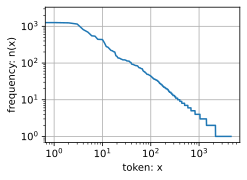

In [30]:
words = text.split()
vocab = Vocab(words)
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

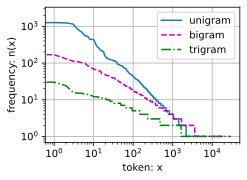

In [31]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
trigram_tokens = ['--'.join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])


# RNN model

$\mathbf{H}_{t} = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh} + \mathbf{b}_{h})$

while the output layer is

$\mathbf{O}_{t} = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_{q}$

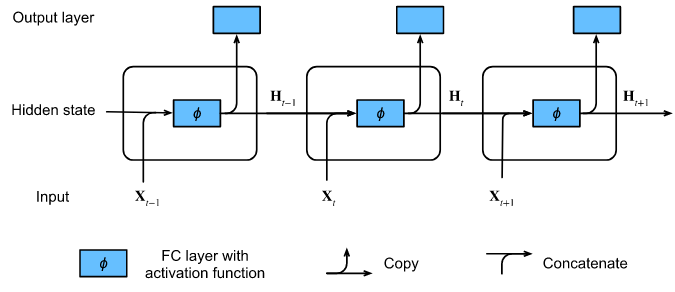

In [32]:
class RNNScratch(nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma
        self.W_xh = nn.parameter.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.parameter.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.parameter.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is not None:
            state, = state
        outputs = []
        # input.shape = (num_steps, batch_size, num_inputs)
        for X in inputs:
            state = torch.tanh(torch.matmul(X, self.W_xh) + (torch.matmul(state, self.W_hh) if state is not None else 0) 
                                + self.b_h)
            outputs.append(state)
        return outputs, state
        

In [33]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

# RNN-based Language Model

In [35]:
class RNNLMScratch(d2l.Classifier):
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size #is output size
        self.lr = lr
        self.init_params()

    def init_params(self):
        self.W_hq = nn.parameter.Parameter(torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.parameter.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

    def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict `num_preds` steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])


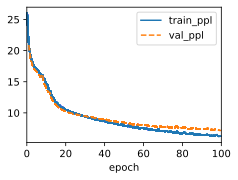

In [17]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data) 

In [21]:
model.predict('it has a', 25, data.vocab, d2l.try_gpu())

'it has a ment and the pace the ti'